# RLC Circuit Network Analysis
## Numerically calculating the response of a complicated RLC network

This notebook will step it up a bit from the example found in the FFT directory called RC_Filters_in_Python. What if the circuits get rather complicated?

There are a number of functions in the scipy.signal package that make it easy to analyze circuits. We will explore a few of them here. Note that with a bit of extra code, you can still do the exact same thing we did in the RC_Filters_in_Python notebook.

We still use the impedance definition for a resistor, $Z_R=R$, a capacitor, $Z_C=1/(i\omega C)$ and an inductor, $Z_L=i\omega L$. We use the same circuit rules as we learned for resistors, but now we have those pesky complex numbers to deal with. The circuit below could be the input stage for a short wave radio, connected to a $50 \omega$ antenna cable (R). Here is an example schematic to analyze:

<img src="rlc_circuit.pdf" alt="RLC circuit" style="width: 200px;"/>

See also: https://www.partsim.com/simulator#71933

If we use our resistor network knowledge, we have a total $Z_tot$ of
$$ Z_{tot} = Z_R + Z_L + Z_C = R + i\omega L + \frac{1}{i \omega C} $$

What we want is the *transfer function* for $V_{out}$ which is the voltage across the capacitor, or the gain across the capacitor $G_C$. You find this from:
$$ G_C = \frac{Z_C}{Z_{tot}} $$
Now we would need to do the complex math to simply this. Python to the rescue! Python has a symbolic math system built in, called sympy.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sympy
import scipy.signal as signal
R = sympy.Symbol("R")  # Define R as a symbol for sympy
C = sympy.Symbol("C")
L = sympy.Symbol("L")
w = sympy.Symbol("w")     # omega
ZL = sympy.I * w * L      # sympy.I is the complex i
ZC = 1/(sympy.I * w * C)  # define ZL, ZC
GC = ZC/(R+ZL+ZC)         # Our transfer function
sympy.simplify(GC)        # Simplify this please in the defined symbols

-I/(C*w*(I*L*w + R) - I)

Thanks! We thus find:
$$ G_C = \frac{-i}{C\omega(iL\omega+R)-i} = \frac{-i}{ (LC\omega^2 - 1)i + RC\omega} = \frac{1}{RC\omega i + (1-LC\omega^2)}$$
Note that this, and nearly anything with RLC components in them you can think of, can be expressed in the general form:

$$F = \frac{n_0S^2+n_1S+n_2}{d_0 S^2+d_1 S+ d_2}$$

where $s = i\omega$. If you need to, you can add terms as you wish, however, note the order is reversed from what you expect!

So we have for the numerator: 1, for the denomenator: $LC(i\omega)^2 + RC i\omega + 1$

We can now feed our transfer function in this form into scipy.signal and make a Bode plot for a range of values for R = 1,4,10,40,100

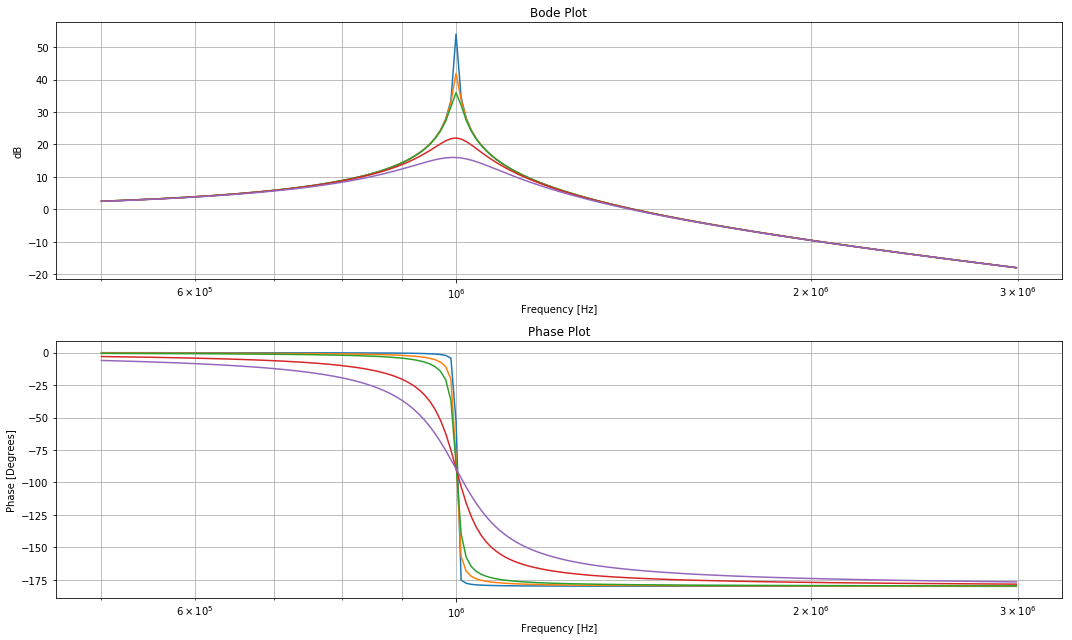

In [2]:
l = 100.e-6  # 100 micro Henry
c = 253.e-12 # 253 pico Farad
r_range=[1.,5.,10.,50.,100.]
plt.figure(figsize=(15,9))
for r in r_range:
    num = [1]
    den = [l*c,r*c,1]
    s1 = signal.lti(num,den)
    freqs=np.arange(5.e5, 3.e6, 10e3)  # A list of frequencies to plot
    omegas=2.*np.pi*freqs               # Convert the frequencies to omega.
    (w, mag, phase) = signal.bode(s1, omegas.tolist()) # Create a Bode plot.
#    ww = np.array(w)
#    ff = ww/(2*np.pi)  This gives the same array as freqs
    plt.subplot(2,1,1)
    plt.plot(freqs,mag) # Plot the amplitude, the absolute of the complex number
    plt.title("Bode Plot")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("dB")
    plt.xscale("log")           # Set x to a log scale
    plt.grid(True,which='both')
    plt.subplot(2,1,2)
    plt.plot(freqs,phase) # Plot the amplitude, the absolute of the complex number
    plt.title("Phase Plot")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Phase [Degrees]")
    plt.xscale("log")           # Set x to a log scale
    plt.grid(True,which='both')

plt.tight_layout()    
plt.show()



Note how much gain you get in the case where R is small. In reality, that would mean a coil for the inductor using thick wire, which gets bulky and expensive. We also ignore the self-capacitance of the coil, which is the capacitance between the windings. For more on making your own RF coils, see: http://www.arrl.org/files/file/Technology/tis/info/pdf/9708033.pdf

Now, how do we show the response to a square wave input?
There are handy functions for this as well in the signal package of scipy. Here is the code to show the response to a square wave of 50kHz.

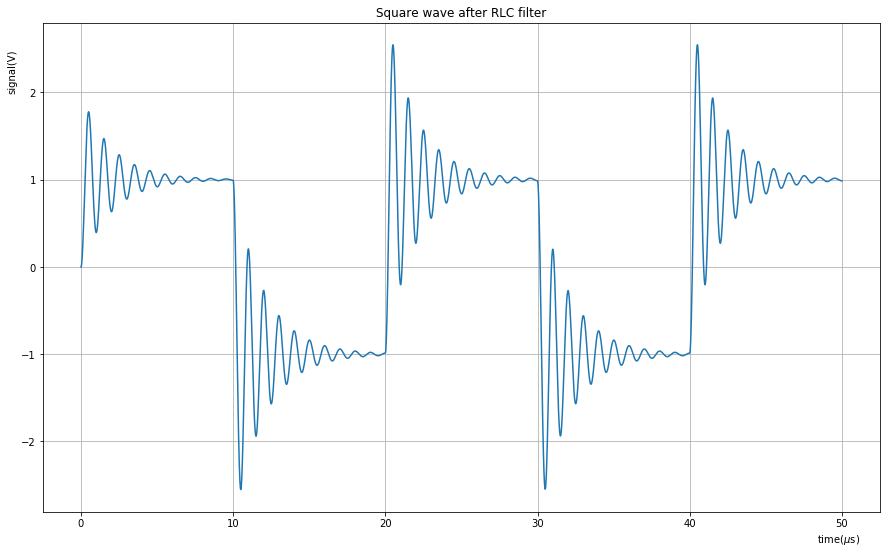

In [3]:
F = 50.e3
T = 50.e-6
N = 5000
DT = T/N
t = np.linspace(0.,T,N)
y_sq = signal.square(2*np.pi*F*t) 
(tt,Vout,xx) = signal.lsim(s1,y_sq,t)
plt.figure(figsize=(15,9))
plt.plot(1000000*t,Vout)
#ax = plt.gca()
#ax.set_xlim(0.,50.)               # Show only the first 50 us of the signal
plt.grid(True)
plt.title("Square wave after RLC filter")
plt.xlabel("time($\mu$s)",position=(0.95,1))
plt.ylabel("signal(V)",position=(1,0.9))
plt.show()